
# MSM of Brownian dynamics simulations of diffusion on a 2D mueller potential
The mueller potential was introduced by K. Muller and L. D. Brown in *Theo. Chim. Acta (Berl.)* **53**, 75-93 (1979):
\begin{equation}
    V(x,y) = \sum_{j=1}^{4}A_{j} \cdot \exp(a_{j}(x-X_{j}^{0})^{2}+b_{j}(x-X_{j}^{0})(y-Y_{j}^{0})+c_{j}(y-Y_{j}^{0})^{2})
\end{equation}
where $a$=(-1,-1,-6.5,0.7); $b$=(0, 0, 11, 0.6); $c$=(-10,-10,-6.5, 0.7); $A$=(-200,-100,-170, 15); $X^{0}$=(1, 0,-0.5,-1); $Y^{0}$=(0, 0.5, 1.5, 1)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
from collections import OrderedDict

Download brownian trajectory from [here](https://drive.google.com/drive/folders/1XXlBtAvd-GPf1pzaonolJgyWRa_Xel6t), and read the latter by using trajectory from COSSIO generator.

In [2]:
import h5py
h5file = "data/mueller_x-1_y0.5_dt0.0001.h5"
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()

### Trajectory analysis and assignment
We discretize the trajectory by a 2D binning, so the mueller potential is divided in microstates (plot 1). In consequence, both x and y coordinates merge onto a s coordinate (plot 2).

In [3]:
# Define the mueller potential according to the V(x,y) shown above
def fmueller(x, y):
    """
    Functional form of the mueller potential

    x : float
        Value of molecular coordinate x.

    y : float
        Value of molecular coordinate y.

    """
    A1, A2, A3, A4 = [-200.0, -100.0, -170.0, 15.0]
    a1, a2, a3, a4 = [-1.0, -1.0, -6.5, 0.7]
    b1, b2, b3, b4 = [0.0, 0.0, 11.0, 0.6]
    c1, c2, c3, c4 = [-10.0, -10.0, -6.5, 0.7]
    x01, x02, x03, x04 = [1.0, 0.0, -0.5, -1.0]
    y01, y02, y03, y04 = [0.0, 0.5, 1.5, 1.0]

    return A1*np.exp(a1*(x-x01)**2 + b1*(x-x01)*(y-y01) + c1*(y-y01)**2)+ \
      A2*np.exp(a2*(x-x02)**2 + b2*(x-x02)*(y-y02) + c2*(y-y02)**2)+ \
      A3*np.exp(a3*(x-x03)**2 + b3*(x-x03)*(y-y03) + c3*(y-y03)**2)+ \
      A4*np.exp(a4*(x-x04)**2 + b4*(x-x04)*(y-y04) + c4*(y-y04)**2)

In [4]:
# Discretize trajectory and plot onto the mueller potential
discret = np.zeros(data.shape[0])
statistic, x_edge, y_edge, binnumber = \
    scipy.stats.binned_statistic_2d(data[:,1], data[:,2], discret, 'count', \
    bins=[np.linspace(np.amin(data[:,1]), np.amax(data[:,1]),6), \
    np.linspace(np.amin(data[:,2]), np.amax(data[:,2]),6)], expand_binnumbers=False)

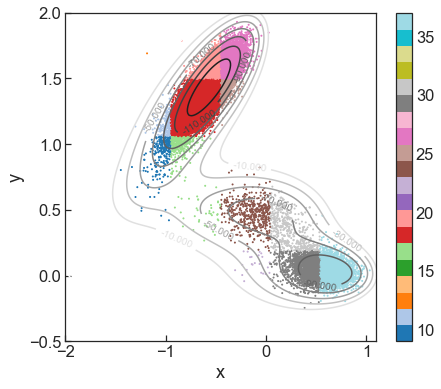

In [5]:
y = np.linspace(-0.5,2.,200)
x = np.linspace(-2.,1.1,200)
M = np.zeros((len(x), len(y)))
lines = []
for i, x_i in enumerate(x):
    for j, y_i in enumerate(y):
        aux = fmueller(x_i,y_i)
        if aux < 100: M[i, j] = aux
X, Y = np.meshgrid(x,y)

fig, ax = plt.subplots(figsize=(6.75, 5.75))
levels = np.arange(-150.0, 20.0, 20)
CS = ax.contour(X, Y, M.T, levels, cmap='binary_r')
ax.clabel(CS, inline=0.9, fontsize=10)
cmaps = OrderedDict()
cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent', \
                        'Dark2', 'Set1', 'Set2', 'Set3', \
                        'tab10', 'tab20', 'tab20b', 'tab20c']
plt.scatter(data[:,1], data[:,2], c=binnumber, cmap=plt.get_cmap('tab20'), s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar()
plt.tight_layout()

<function matplotlib.pyplot.show(*args, **kw)>

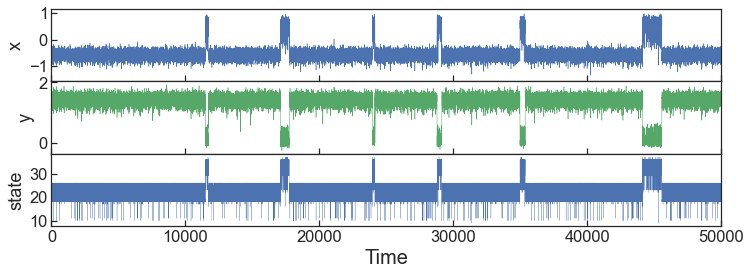

In [6]:
fig,ax=plt.subplots(3, 1, figsize=(12,4), sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].plot(range(0,len(data[:,1])), data[:,1], lw=0.5)
ax[1].plot(range(0,len(data[:,2])), data[:,2], color="g", lw=0.5)
ax[2].plot(binnumber, lw=0.25)
ax[0].set_ylabel('x')
ax[1].set_ylabel('y')
ax[2].set_ylabel("state")
ax[2].set_xlabel("Time", fontsize=20)
ax[0].set_xlim(0,50000)
plt.show

### MSM: convergence test
First, we build an instance of `TimeSeries` class to find the strongly connected states corresponding to the assignment shown above. Then, we use the `SuperMSM` class to study the dependence of the relaxation times, $\tau_i$, on the lag time $\Delta t$ adopted to build the transition matrix.

In [7]:
# MASTER EQUATION MODEL
from mastermsm.trajectory import traj
from mastermsm.msm import msm

distraj = traj.TimeSeries(distraj=list(binnumber), dt=1)
distraj.find_keys()
distraj.keys.sort()
msm_2D = msm.SuperMSM([distraj],sym=True)

# CONVERGENCE test
import random
rand = lambda: random.randint(0, 255)
msm_2D.convergence_test(time=[1, 5, 10, 50, 100, 500, 1000], error=True)

     # states: 18
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing


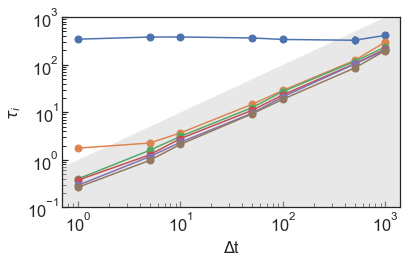

In [8]:
fig, ax = plt.subplots()
for i in range(0,6):
    tau_vs_lagt = np.array([[x, msm_2D.msms[x].tauT[i], msm_2D.msms[x].tau_std[i]] \
               for x in sorted(msm_2D.msms.keys())])
    ax.errorbar(tau_vs_lagt[:,0], tau_vs_lagt[:,1], tau_vs_lagt[:,2], marker='o', ms=7)
ax.set_xlabel(r'$\Delta$t ', fontsize=16)
ax.set_ylabel(r'$\tau_i$', fontsize=16)
ax.set_xscale('log')
ax.set_yscale('log')
ax.fill_between(10**np.arange(-1,4,0.2), 1e-1, 10**np.arange(-1,4,0.2), facecolor='lightgray', alpha=0.5)
ax.set_ylim(1e-1,1000)
ax.set_xlim(0.7,1400)
plt.tight_layout()

### MSM: validation
Once a proper lag time is chosen, we generate a MSM and plot the autocorrelation corresponding to the left eigenvectors (Buchete et al. JPCB 2008), as well as the spectrum of (logarithm of) relaxation times.

 symmetrizing


<function matplotlib.pyplot.show(*args, **kw)>

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


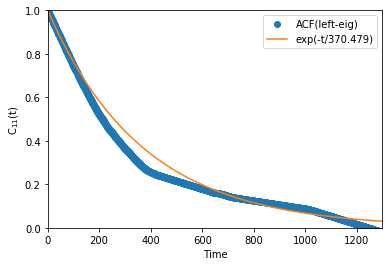

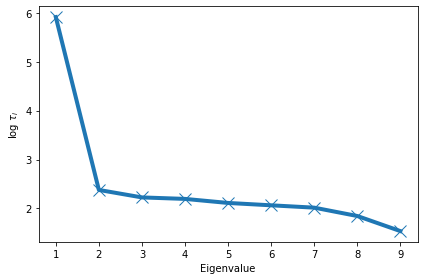

In [7]:
lagt=40
msm_2D.do_msm(lagt)
msm_2D.msms[lagt].do_trans(evecs=True)

# VALIDATION - AUTOCORRELATION FUNCTION (acf)
acf = msm_2D.msms[lagt].acf_mode()
time = np.arange(len(acf[1]))*msm_2D.data[0].dt
fig, ax = plt.subplots()
ax.plot(time, acf[1], 'o', label='ACF(left-eig)')
ax.plot(time,np.exp(-time*1./msm_2D.msms[lagt].tauT[0]), \
            label='exp(-t/%5.3f)' % msm_2D.msms[lagt].tauT[0])
ax.set_ylim(0,1)
ax.set_xlim(0,1300)
ax.set_xlabel('Time')
ax.set_ylabel('C$_{11}$(t)')
ax.legend()
plt.show

# Spectrum of relaxation times
fig, ax = plt.subplots()
ax.plot(range(1,len(msm_2D.msms[lagt].tauT)+1), \
            np.log(msm_2D.msms[lagt].tauT), 'x-', markersize=12, linewidth=4)
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'log $\tau_i$')
plt.tight_layout()
plt.show

The first mode captured by $\lambda_1$ is significantly slower than the others. That mode, which is described by the right eigenvector $\psi^R_1$ as the transition between the two main minima. Next plots correspond to the eigenvector and its projection on the mueller potential.

<function matplotlib.pyplot.show(*args, **kw)>

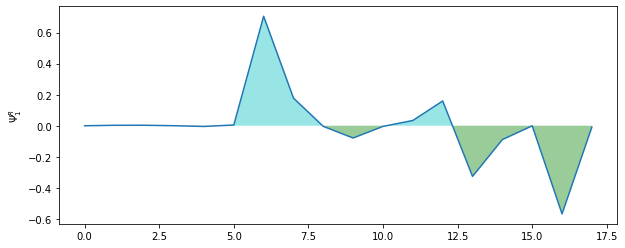

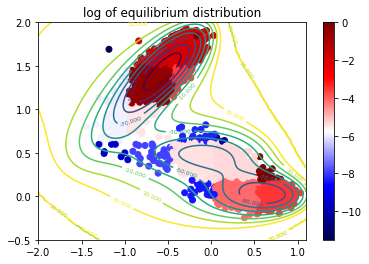

In [9]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(msm_2D.msms[lagt].rvecsT[:,1])
ax.fill_between(range(len(msm_2D.msms[lagt].rvecsT[:,1])), 0, \
                msm_2D.msms[lagt].rvecsT[:,1], \
                where=msm_2D.msms[lagt].rvecsT[:,1]>0,\
                facecolor='c', interpolate=True,alpha=.4)
ax.fill_between(range(len(msm_2D.msms[lagt].rvecsT[:,1])), 0, \
                msm_2D.msms[lagt].rvecsT[:,1], \
                where=msm_2D.msms[lagt].rvecsT[:,1]<0,\
                facecolor='g', interpolate=True,alpha=.4)
ax.set_ylabel("$\Psi^R_1$")
plt.show

# 2D projection
binnumber2 = np.zeros(len(data[:,1]))
for i in range(len(binnumber)-1):
    j = binnumber[i]
    for k in range(len(msm_2D.msms[lagt].keep_keys)-1):
        if j==msm_2D.msms[lagt].keep_keys[k]:
            binnumber2[i] = np.log(msm_2D.msms[lagt].peqT[k])
            break
y = np.linspace(-0.5,2.,200)
x = np.linspace(-2.,1.1,200)
M = np.zeros((len(x), len(y)))
lines = []
for i, x_i in enumerate(x):
    for j, y_i in enumerate(y):
        aux = fmueller(x_i,y_i)
        if aux<100: M[i, j] = aux
X, Y = np.meshgrid(x,y)
fig, ax = plt.subplots()
levels = np.arange(-130.0, 40.0, 20)
CS = ax.contour(X, Y, M.T, levels)
ax.clabel(CS, inline=0.9, fontsize=6)
cmaps = OrderedDict()
cmaps['Diverging'] = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
plt.scatter(data[:,1],data[:,2],c=binnumber2,cmap=plt.get_cmap('seismic'))
plt.colorbar()
plt.title('log of equilibrium distribution')
plt.show